In [97]:
import numpy as np
from scipy.signal import find_peaks
from astropy import constants, units
import numpy as np
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd


In [109]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    #bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux

In [114]:
def vsini(wave, flux, epsilon=0.6, clam=None, window=None):
    cc = constants.c.to(units.AA / units.s).value

    if window is not None:
        keep = (window[0] <= wave) & (wave <= window[1])
        wave, flux = wave[keep], flux[keep]

    clam = clam or np.mean(wave)

    q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

    freqs, ampls = np.fft.fftfreq(len(wave), 0.05), np.abs(np.fft.fft(1 - flux))
    ampls /= max(ampls)

    peaks, _ = find_peaks(-ampls)
    minima = freqs[peaks][:-1]
    minvals = ampls[peaks][:-1]

    freqs = freqs * clam / q1 / cc
    vsini_values = cc / clam * q1 / minima

    error = np.ptp(wave) * clam / q1 / cc

    return (freqs, ampls), (minima, minvals), vsini_values/10**13, error

In [116]:
clam = 6678
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
result = vsini(wave, flux, clam = clam, window=[6670, 6686])
print('V(FT) is', max(result[2]), 'km/s')

V(FT) is 170.37507963936184 km/s


/tmp/ipykernel_15249/213789176.py:8: RuntimeWarning: divide by zero encountered in divide
  return (cc / clam * q1 / freqs)/10**13


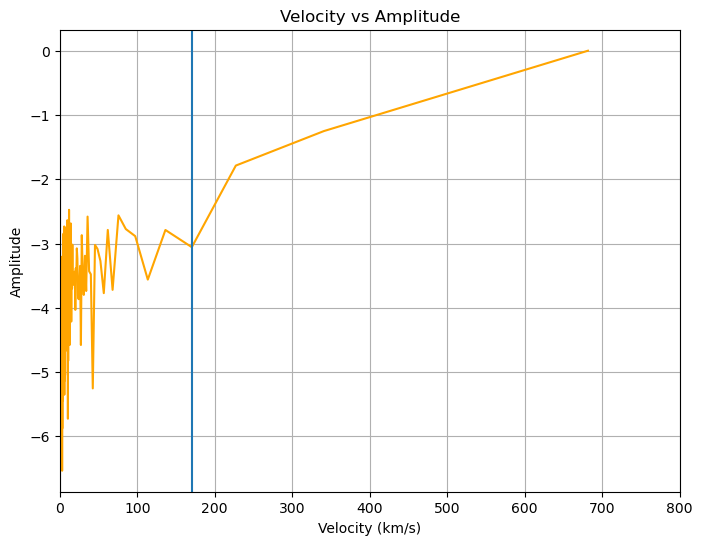

In [117]:

epsilon = 0.6
cc = constants.c.to(units.AA / units.s).value
q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4
freqs = result[0][0] /( clam / q1 / cc)
ampls = result[0][1]
def freq_to_velocity(freqs, clam, q1):
    cc = constants.c.to(units.AA / units.s).value
    return (cc / clam * q1 / freqs)/10**13

# Convert frequencies to velocities
velocities = freq_to_velocity(freqs, clam, q1)
log_ampls = np.log(ampls)

# Plot velocity vs amplitude
plt.figure(figsize=(8, 6))
plt.plot(velocities, log_ampls, color = 'orange')
plt.ylabel('Amplitude')
plt.xlabel('Velocity (km/s)')
plt.title('Velocity vs Amplitude')
plt.grid(True)
plt.xlim(0,800)
plt.axvline(max(result[2]))
#plt.ylim(0,0.1)
plt.show()